## Import Libraries Used and add helper functions

In [52]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.saving import load_model, save_model
import os
from PIL import Image
from time import perf_counter
import numpy as np
import pandas as pd
import pickle
#from IPython.display import Image, display
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
'''
This contains help functions. The class 'Model' stores the keras models, and also relevant information about the model
'''

class Model:
    def __init__(self, train_data, val_data, model, name = 'Model'):
        self.train_data = train_data
        self.val_data = val_data
        self.model = model
        self.name = name
        self.lr = 0.0005
    
    def fit(self, epochs):
        ''' Calls the fit function for the model'''
        st = perf_counter()
        history = self.model.fit(train_data,validation_data = val_data ,steps_per_epoch=self.train_data.n // 64, epochs=epochs)
        self.history = history.history
        self.epochs = epochs
        et = perf_counter()
        self.runtime = et-st
    def show_accuracy_chart(self):
        '''Show a chart of the accuracy of the model '''
        train_acc =  self.history['accuracy']
        val_acc = self.history['val_accuracy']
        fig, ax = plt.subplots()
        ax.plot(range(self.epochs), train_acc, label = 'Training')
        ax.plot(range(self.epochs), val_acc,   label = 'Validation')
        ax.set_ylim([.5, 1])
        plt.title(f"{self.name}")
        ax.legend()
    
        plt.show()
    def summary(self):
        self.model.summary()
        
    def compile(self, *args, **kwargs):
        '''Compiles the models, and just passes arguements through'''
        self.model.compile(*args, **kwargs)

def generate_data(batch_size=64, percentage_dataset=.25, percentage_train=.2):
    '''This will take the Kaggle dataset and randomly select a specific portion of it to help. This will help
    computation speed up, but at the expense of accuracy
    '''
    
    #Reduce number of rows used to speed up commpuation at the expense of accuracy
    train_labels_small = train_labels.sample(frac = percentage_dataset, random_state = 648).reset_index()
    train_labels_small['id'] =  train_labels_small['id'].astype(str) + '.tif'
    train_labels_small['label'] = train_labels_small['label'].astype(str)
    
    # calculate train validation split
    X_train = train_labels_small.sample(frac = percentage_train, random_state = 59)
    val_train = train_labels_small.drop(X_train.index)

    # Generate Data sets
    data = ImageDataGenerator()
    train_data = data.flow_from_dataframe(X_train,
                                          directory="/kaggle/input/histopathologic-cancer-detection/train",
                                          target_size=(96, 96), 
                                          x_col='id',
                                          y_col = "label",
                                          class_mode='binary',
                                          batch_size=batch_size,
                                          shuffle=False,
                                          validate_filenames = False)
    val_data = data.flow_from_dataframe(val_train, 
                                        directory="/kaggle/input/histopathologic-cancer-detection/train",
                                        target_size=(96, 96), 
                                        x_col='id',
                                        y_col = "label",
                                        class_mode='binary',
                                        batch_size=64,
                                        shuffle=False,
                                        validate_filenames = False)
    
    
    return train_data, val_data

def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        st = perf_counter()
        
        res = func(*args, **kwargs)
        duration = perf_counter()- st
        print(f'{duration} seconds or {duration/60} minutes')
        
def loop_models(train_data, val_data, model_list, epochs, lr = 0.0005, sum_only = False):
    '''
    Takes a list of models and a dictionary, creates the models and saves them to the dictionary. 
    Each list should have a name of the model, followed by a list of the parameters for the architecture
    '''
    d = {}
    for i, params in enumerate(model_list):
        #Make sure that the same inital weights are used-
        tf.random.set_seed(846)
        tf.keras.backend.clear_session()
        
        print(f'Model: {params[0]}')
        
        tmp_model = build_model(params,train_data, val_data, model_list, epochs, lr, sum_only)
        if sum_only == False:
            tmp_model.fit(epochs)
            d[params[0]] = tmp_model
            return d
        else:
            print(tmp_model.summary())
    
def build_model(params, train_data, val_data, model_list, epochs, lr, sum_only = False):
    '''
    Builds a model, and allows a learning rate to be set
    '''
    tmp_model = Model(train_data, val_data, Sequential(params[1]), name = params[0])
    tmp_model.lr = lr
    tmp_model.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=['accuracy'])
    return tmp_model


def plot_model_acc_together(d):
    '''
    
    '''
    fig, ax = plt.subplots()
    #ax.plot(range(self.epochs), val_acc,   label = 'Validation')
    for model in d:
        train_acc = (d[model].history['accuracy'])
        epochs = len(train_acc)
        print(train_acc)
        ax.plot(range(1,epochs+1), train_acc, label = model)
        
    ax.set_ylim([.5, 1])
    plt.title('Accuracy')
    ax.legend()
    plt.show()

def plot_model_loss_together(d):
    
    fig, ax = plt.subplots()
    #ax.plot(range(self.epochs), val_acc,   label = 'Validation')
    for model in d:
        train_acc = (d[model].history['loss'])
        epochs = len(train_acc)
        print(train_acc)
        ax.plot(range(1,epochs+1), train_acc, label = model)
        
    ax.set_ylim([.5, 1])
    plt.title('Accuracy')
    ax.legend()
    plt.show()
    
    
def plot_all_plots_acc(d):
    """Plot accuracy functions of all histories in a dictionary"""
    
    total_plots = len(d)
    plt.figure(figsize = (15,np.ceil(total_plots/3)*9))
    rows = int(np.ceil(total_plots/2))
    
    # Postion differently depending on amount of rows
    title_y = .98
    if rows >= 3:
        title_y = .9
    #Set the amount of columns
    cols = 3
    if total_plots < 3:
        cols = total_plots    
    
    for i, model in enumerate(d):
        train_acc =  d[model]['history']['accuracy']
        val_acc = d[model]['history']['val_accuracy']
        plt.subplot(rows, cols, i+1)
        plt.plot(range(d[model]['epochs']), train_acc, label = 'Training')
        plt.plot(range(d[model]['epochs']), val_acc,   label = 'Validation')
        plt.ylim([.5, 1])
        plt.title(f"{model}")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        #plt.ylabel = 'test'
        #fig.add_subplot(rows, 2, i+1)
        plt.legend()
    #ax.legend()
    plt.suptitle('Accuracy', fontsize=20, y = title_y)
    plt.show() 

def plot_all_plots_loss(d):
    """Plot loss functions of all histories in a dictionary"""
    
    total_plots = len(d)
    plt.figure(figsize = (15,np.ceil(total_plots/3)*9))
    rows = int(np.ceil(total_plots/2))
    
    # Postion differently depending on amount of rows
    title_y = .98
    if rows >= 3:
        title_y = .9
    
    #Set the amount of columns
    cols = 3
    if total_plots < 3:
        cols = total_plots
    
    for i, model in enumerate(d):
        train_acc =  d[model]['history']['loss']
        val_acc = d[model]['history']['val_loss']
        plt.subplot(rows, cols, i+1)
        plt.plot(range(d[model]['epochs']), train_acc, label = 'Training')
        plt.plot(range(d[model]['epochs']), val_acc,   label = 'Validation')
        plt.ylim([0, 1])
        plt.title(f"{model}")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        #plt.ylabel = 'test'
        #fig.add_subplot(rows, 2, i+1)
        plt.legend()
    #ax.legend()
    plt.suptitle('Loss', fontsize=20, y = title_y)
    plt.show()    
    
def pickle_out(filename, object):
    """Write an object out to the directory /pickles"""
    filename = filename
    pickling_on = open(filename, "wb")
    pickle.dump(object, pickling_on)
    pickling_on.close()

def save_loop_info(prefix, d):
    """
    Saves a dictionary with the history, and other run information for the loop function
    """
    
    #model_dict
    save_histories = {}
    # Export the models
    for each in d:
        #print(each)
        d[each].model.save(f"{prefix}_{each}.tf")
        #Export a dictionary witht he history information
        save_histories[each] = {'history': d[each].history, 'runtime':d[each].runtime, 'epochs':d[each].epochs, 'learning_rate':d[each].lr}
        #save_histories[each] = save_model_info(d[each])
    pickle_out(f'{prefix}.pickle', save_histories)

def save_model_info(model):
    """Imports a Model class and saves the information from it, creates a dictionary"""
    d = {}
    d[model.name] = {'history': model.history, 'runtime':model.runtime, 'epochs':model.epochs, 'learning_rate':model.lr}
    print(d)
    return d

def combine_dictionarys (d_list, new_name):
    
    new_loss = []
    new_accuracy = []
    new_val_loss = []
    new_val_accuracy = []
    new_runtime = 0
    new_epochs = 0
    lr = 0
    
    #Loop through dictionaries and add them
    for i in d_list:
        for j in i:
            new_loss += i[j]['history']['loss']
            #print(i[j]['history']['loss'])
            new_accuracy += i[j]['history']['accuracy']
            new_val_loss += i[j]['history']['val_loss']
            new_val_accuracy += i[j]['history']['val_accuracy']
            new_runtime += i[j]['runtime']
            new_epochs += i[j]['epochs']
            lr = i[j]['learning_rate']
    new_d = {}
    new_d[new_name] = {'history': {'loss': new_loss, 'accuracy': new_accuracy, 'val_loss': new_val_loss, 'val_accuracy':new_val_accuracy},
                       'runtime' : new_runtime, 'epochs':new_epochs, 'learning_rate': lr}
    return new_d

def create_summary_table(d):
    """Creates a summary table from a dictionary"""

    max_acc = []
    min_loss = []
    max_val_acc = []
    epoch_min_val_loss = []
    min_val_loss = []
    row_names = []

    for each in d:
        max_acc.append(max(d[each]['history']['accuracy']))
        min_loss.append( min(d[each]['history']['loss']))
        max_val_acc.append(max(d[each]['history']['val_accuracy']))
        min_val_loss.append(min(d[each]['history']['val_loss']))
        epoch_min_val_loss.append(np.argmin(d[each]['history']['val_loss']))
        row_names.append(each)
    df = pd.DataFrame(list(zip(row_names, max_acc,min_loss, max_val_acc, min_val_loss, epoch_min_val_loss)),
                     columns = ['Model','Max Acc', 'Minnimum Loss','Max Val Acc','Min Val Loss','Epoch of Min Val Loss']).round(3)
    display(df)

In [3]:
cwd = os.getcwd()
cwd

'/kaggle/working'

In [4]:
# Copy all saved input files to the Kaggle working directory
os.popen(f'cp /kaggle/input/run1-data/* {cwd}')
os.listdir(cwd)

['.virtual_documents', '__notebook_source__.ipynb']

# Intro
### Note on workflow: 
This project was done with a Kaggle notebook, in multiple sessions. Data was downloaded either as a pickle or a model between runs. Once the runs were done and exported, I commented out the lines that created the data. If you would like to completly duplicate my work, those lines would have to be uncomemnted out. 

I then added these pickles and models to a Kaggle dataset, which I copied in the working directory at the begining of each session. The data files are also avaliable on Github at https://github.com/highdeltav/DeepLearningWeek3.

# Problem and Data
This dataset is a set composed of images from Kaggle that depict pictures that might have a tumor in them or not. These pictures would be used in order to create a model that would help identify the presence of tumors, which would in turn lead to earlier treatment,and better medical outcomes.  The dataset can be found https://www.kaggle.com/competitions/histopathologic-cancer-detection/data. There are 220,025 different images in the training test set. Each image is 96x96 pixels. Each pixcel is a value between 0 and 255 and these pixels are contained on three different layers, representing RGB. All of the pictures either contain tumor cells or they do not, and are the actual values are listed in a separate dataframe for training. Approximately 40 percent of the training images contain an image with a tumor. Since it only has two categories,this dataset lends itself to to binary classification. 

## EDA

For my inital EDA, I imported the list of images into panda data frames. I did some basic data verification, like making sure there were no labels other than '0' or '1'. I verifed this through a summary, histogram and a search of the data frame. 

Another aspect of the images that I looked into was how many of the images contained a tumor, so I calculated that to be just over 40 percent of the images. 

The last thing that I did, is I wanted to see what the images looked like that I was trying to classify, so I pulled 12 random random samples of the dataset. It is a very small sample of the dataset, but I did verify that on at least the sampled images, they were equal to 96x96 pixels. 

In [5]:
#print(os.listdir('/kaggle/input/histopathologic-cancer-detection/'))
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

In [6]:
print(train_labels.describe())
print(train_labels.head())
print(train_labels['label'].value_counts())


               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
0    130908
1     89117
Name: label, dtype: int64


In [7]:
#Verify there are no rows wwith labels that aren't zero or one.| 
train_labels[~train_labels['label'].isin([1, 0])]

,id,label


0.405 percentage of positive images


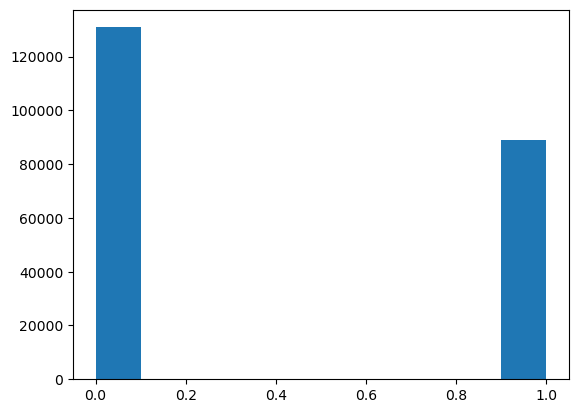

In [8]:
plt.hist(train_labels['label'])
print(f'{np.count_nonzero(train_labels["label"])/len(train_labels):.03f} percentage of positive images')

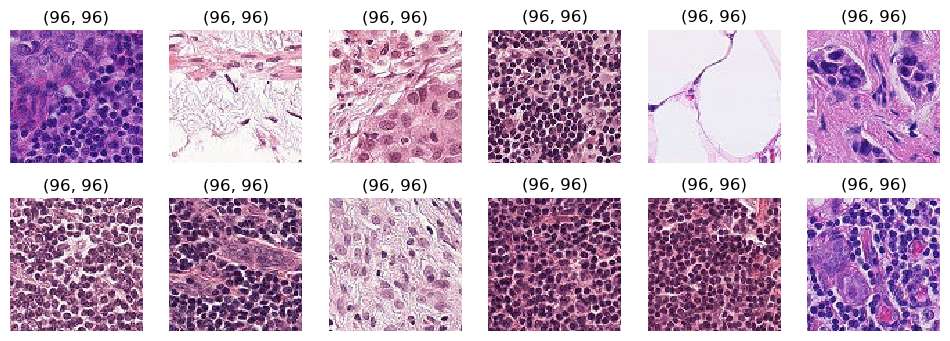

In [9]:
#Show random pictures
np.random.seed(55)
rand_pics = np.random.randint(1, high = len(train_labels), size = 12)
fig=plt.figure(figsize=(12,4))

for i, pic_index in enumerate(rand_pics):
    file_name = train_labels.loc[pic_index,'id']
    #display(Image(filename='/kaggle/input/histopathologic-cancer-detection/train/'+ file_name + '.tif'))
    im = Image.open('/kaggle/input/histopathologic-cancer-detection/train/'+ file_name + '.tif')
    fig.add_subplot(2, 6, i+1)
    plt.imshow(np.array(im), interpolation='nearest')
    plt.axis('off')
    plt.title(im.size)
fig.show()


In [10]:
file_name = train_labels.loc[rand_pics[1],'id']
#display(Image(filename='/kaggle/input/histopathologic-cancer-detection/train/'+ file_name + '.tif'))
im = np.array(Image.open('/kaggle/input/histopathologic-cancer-detection/train/'+ file_name + '.tif'))
print(f"Max Value: {max(im.flatten())}")
print(f"Min Value: {min(im.flatten())}")


Max Value: 255
Min Value: 0


## Pre-processing
Because of the time that training from a large dataset takes, and the constraints of the assignment, I decided to only train on ten percent of the dataset.  I know this reduced accuracy, but it also made it so the data was a manageable size to deal with in a reasonable amount of time. I split this to 80 percent for training and 20 percent for validation. I ended up with 17,602 training images and 4400 validation images. 

Even with the smaller dataset, when I tried to load the entire dataset into Kaggle memory, I kept having crashes. The solution I found was to load the data on the fly with the Keras ‘flow_from_dataframe’ function.

Since CNN works best with values that are between 0 and 1, I normalized the images. Since I was pulling images from a directory on the fly, this is done in the model itself as part of the first layer. 

In [11]:
# Create the the training and validation
train_data, val_data = generate_data(batch_size=64, percentage_dataset=.1, percentage_train=.8)

Found 17602 non-validated image filenames belonging to 2 classes.
Found 4400 non-validated image filenames belonging to 2 classes.


## Architecture
Image classification lends itself to a convoluted neural network, so I will be pursued a CNN that can classify these images. For the input layer,since these are RGB images, I will have three inputs, each with a size of 96 by 96. Since this is a binary classification problem, I am going to start of with a 'Sigmoid' function for my last activation function, with one output. This will give a value between one and zero, with a cutoff of .5 between the two different categories. For my loss function, I also chose binary cross entropy, since it is a binary classification problem.

For the initial architecture, I chose to have one convolution layer, followed by a maxpool layer. Before the output layer, I then flatten the image, and add one more dense layer. This was modified from the Keras tutorial for ‘Image Classification.’  The initial activation functions I chose were ‘Relu,’ since that is a common function that is used in image classification. 

I tried a different architecture called Let5, that I had seen in my reading on the subject (Alake 2020.) In my iteration, I also attempted to implement a model with that architecture.

My images are being run through the network in batches of 64, which is also accomplished with the 'flow_from_data_frame' function.

## Architecture iteration and Analysis
### Iteration
My intiallly started off with six different convulution models and one Let5 model. My six model iterated on themselves, starting with one layer of convulation and then a max pool layer. I then added layers up to a total of six convoluation layers. I then iterated through all of these layers with a learning rate of .0005. This learning rate was a little small, but I wanted to err on the side of getting good results, rather than speed for the inital implmentation. 


In [12]:
model1 = ['1_layer',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]

model2 = ['2_layer',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]


model3 = ['3_layer',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]

model4 = ['4_layer',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]

model5 = ['5_layer',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]

model6 = ['6_layer',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),      
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]
model7 = ['Let5',[
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape =(96,96,3), padding='same'), #C1
    keras.layers.AveragePooling2D(), #S2
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    keras.layers.AveragePooling2D(), #S4
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C5
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='tanh'), #F6
    keras.layers.Dense(1, activation='sigmoid') #Output layer
]]

model8 = ['2c_1mp',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(3, 3, padding='same', activation='relu'),
  layers.Conv2D(3, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]
model9 = ['4c_2mp',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]

model10 = ['6c_3mp',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]


In [13]:
# Create a list of the model for the loop function
model_list = [model1,model2,model3,model4,model5, model6, model7]


In [14]:
# Uncomment out lines if the data needs to be regenerated

#run1_loop = loop_models(train_data, val_data, model_list, 20, lr = .0005)
#pickle_out('model_loop1.pickle', model_dict)
#save_loop_info('run1', run1_loop)

In [15]:
#Run of second architecture

model_list2 = [model8,model9]
#run5_loop = loop_models(train_data, val_data, model_list2, 20, lr = 0.0005)
#save_loop_info('run5', run5_loop)

### Initial Analysis
After iterating through my six similar models and the Let5 model, it became apparent that my models did do better than guessing, but they were also not doing particularly well.  The absolute best model I had was showing .85 for a validation accuracy. The loss was converging to zero for the training models, but the validation loss would descend a little, before climbing, as the model began to have over-fitting. 

I decided to change my architecture slightly, and try two convolution layers for each max pool layer. This however did not result in any significant improvement over my previous models. It was at this point that I decided to focus on one of my models and try and tune some of its hyper parameters to see if I could improve that model more. After looking at my table of values, and also the graphs showing accuracy and loss, I decided to go with the model that had 5 convolution layers, and 5 max pool layers. The biggest reason that I chose this model was it had the lowest validation loss and the highest validation accuracy. However, that was not the only reason that I chose it. The other reason that I chose that model specifically, is that there were less spikes in the loss data overall at it descended, reached its inflection point, and then began to climb again. 

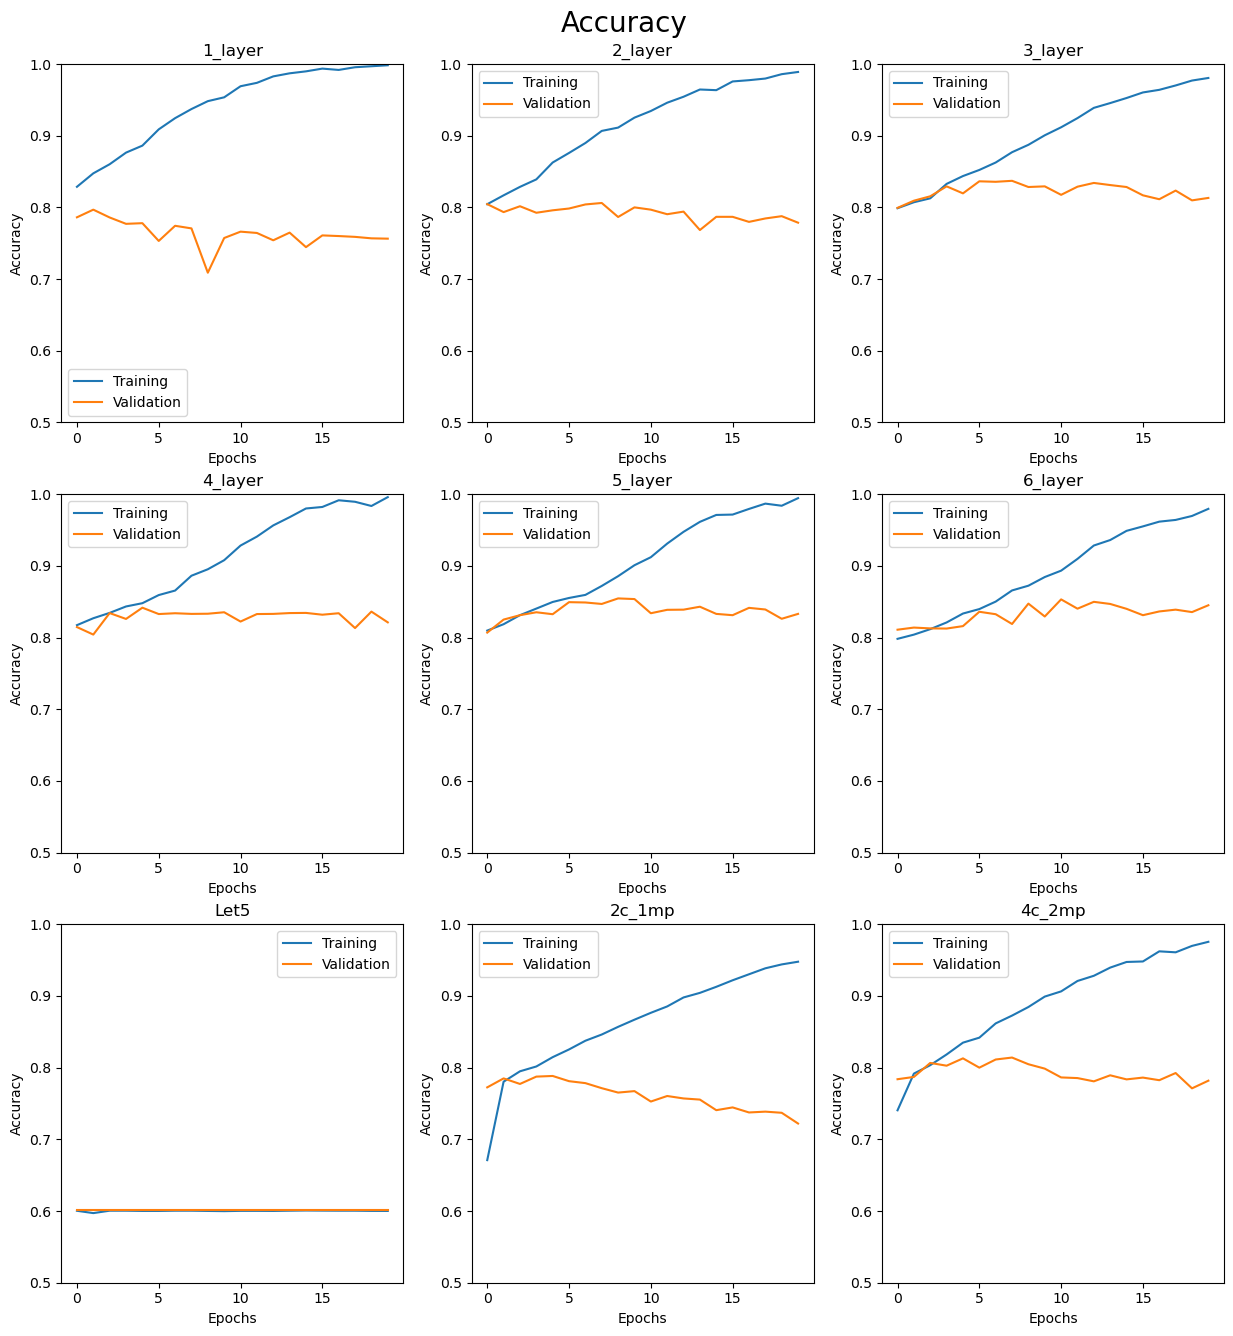

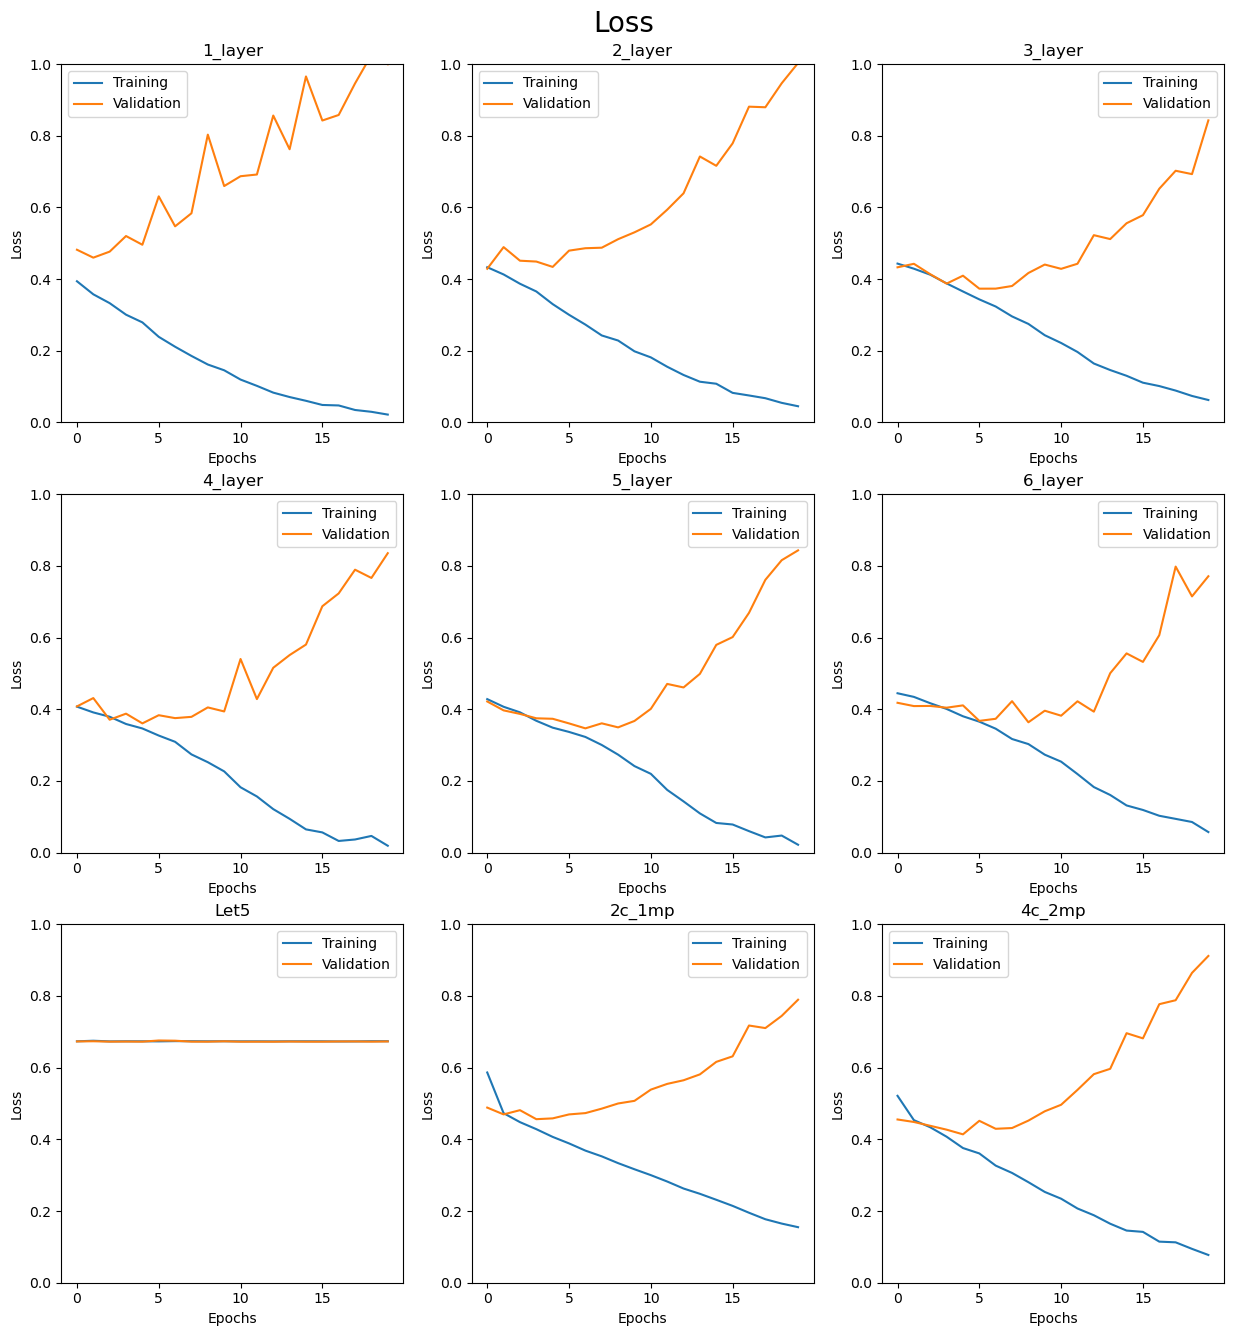

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,1_layer,0.998,0.022,0.797,0.460,1
1,2_layer,0.989,0.045,0.806,0.429,0
2,3_layer,0.980,0.063,0.837,0.373,5
3,4_layer,0.996,0.019,0.842,0.360,4
4,5_layer,0.994,0.022,0.855,0.347,6
5,6_layer,0.979,0.057,0.853,0.364,8
6,Let5,0.601,0.673,0.602,0.672,12
7,2c_1mp,0.948,0.155,0.788,0.456,3
8,4c_2mp,0.976,0.077,0.814,0.414,4


In [16]:
run1 = pd.read_pickle('run1.pickle')
run2 = pd.read_pickle('run5.pickle')
#loop_models(train_data, val_data, model_list, 20, lr = .0005, sum_only = True)
plot_all_plots_acc(run1|run2)
plot_all_plots_loss(run1|run2)
create_summary_table(run1|run2)

# Adjust Hyperparameters
## Learning Rate
Once I had decided on a model to focus on, I began to tune some of the hyperparameters. The first hyper parameter that I decided to adjust was learning rate. I wanted to see if there was an optimal learning rate, or if the rate of .0005 that I initially picked was either too much or too little. I decided to do two more learning rates, for a total of three. One would be larger, one would be smaller and we had already run one in the middle,from our initial set of runs.

In [17]:
# Copy of model 5
model5a = ['5_layer',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]

In [18]:
#Higher Learning rate 01
tf.random.set_seed(846)
run_lr1_model = Model(train_data, val_data, Sequential(model5a[1]), name = 'Learning Rate .001')
run_lr1_model.lr = .001
lr = run_lr1_model.lr
run_lr1_model.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=['accuracy'])
run_lr1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 24, 24, 64)        1

In [19]:
# Uncomment out these lines if the model needs to be rerun
#run_lr1_model.fit(20)
#pickle_out('run_lr_1_test.pickle',save_model_info(run_lr1_model))

In [20]:
run_lr_1 = pd.read_pickle('run_lr_1.pickle')

In [21]:
# Very small learning rate of .00001
tf.random.set_seed(846)

model5b_model = Model(train_data, val_data, Sequential(model5a[1]), name = model5a[0])
model5b_model.lr = .00001
lr = model5b_model.lr

model5b_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=['accuracy'])
model5b_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 24, 24, 64)       

In [22]:
#Uncomment out lines again to rerun data. Model is saved because it needed more epochs

#model5b_model.fit(20)
#pickle_out('run_lr_2.pickle',save_model_info(model5b_model))
#model5b_model.model.save('model5b_model.h5', save_format='h5' )


In [23]:
model5b_model = Model(train_data, val_data, Sequential(model5a[1]), name = model5a[0])
model5b_model.lr = .00001
model5b_model.model = tf.keras.saving.load_model("/kaggle/input/run1-data/model5b_model.h5")

In [24]:
#Uncomment out lines again to rerun data. Model is saved because it needed more epiacjs
#model5b_model.fit(20)

# Save second run data
#pickle_out('run_lr_2b.pickle',save_model_info(model5b_model))
#model5b_model.model.save('model5b_a_model.h5', save_format='h5' )


In [25]:
# Save second run data

#Uncomment out lines again to rerun data. Model is saved because it needed more epiacjs
#pickle_out('run_lr_2b.pickle',save_model_info(model5b_model))
#model5b_model.model.save('model5b_a_model.h5', save_format='h5' )


In [26]:
# Third run

#Uncomment out lines again to rerun data. Model is saved because it needed more epiacjs
#model5b_model.fit(20)
#pickle_out('run_lr_2b.pickle',save_model_info(model5b_model))
#model5b_model.model.save('model5b_b_model.h5', save_format='h5' )

In [27]:
# Combine all three models into one history data
run_lr2 = pd.read_pickle('run_lr_2.pickle')
run_lr2a = pd.read_pickle('run_lr_2a.pickle')
run_lr2b = pd.read_pickle('run_lr_2b.pickle')

### Learning Rate Conclusion
The learning rate of .01 still seemed to converge, and did it slightly faster than .0005. The smaller learning rate also appears to have been converging. However, I ran that learning rate for 60 epochs, and the validation accuracy had not still not converged. What this told me is that .00001 is way to small for the inital trainig of the model. However, it might be good to do some inital epochs with the larger learning rate, and then train some more with the smaller learning rate, to ses if we can squeak out a little more validation accuracy the model begins to overfit on the data. 

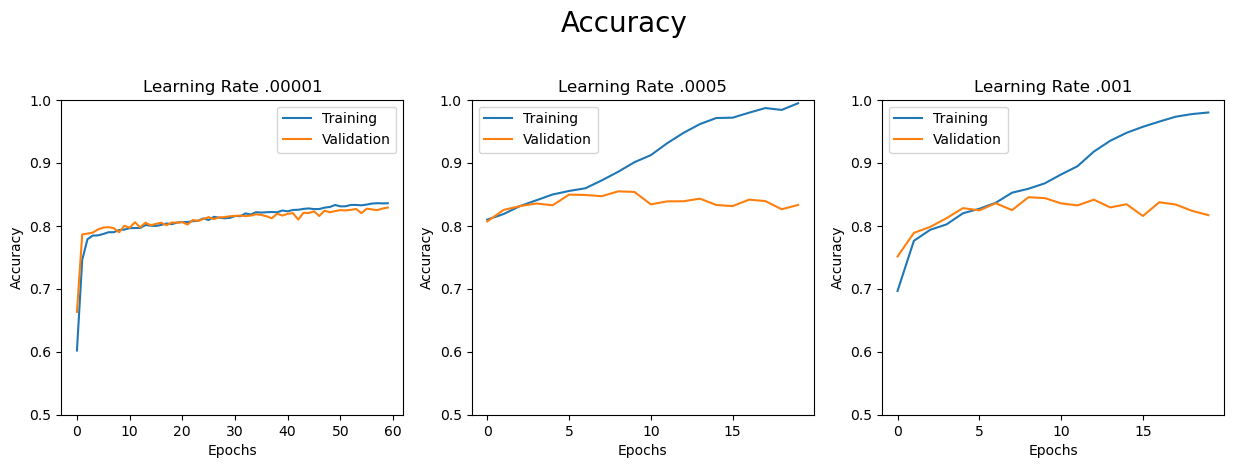

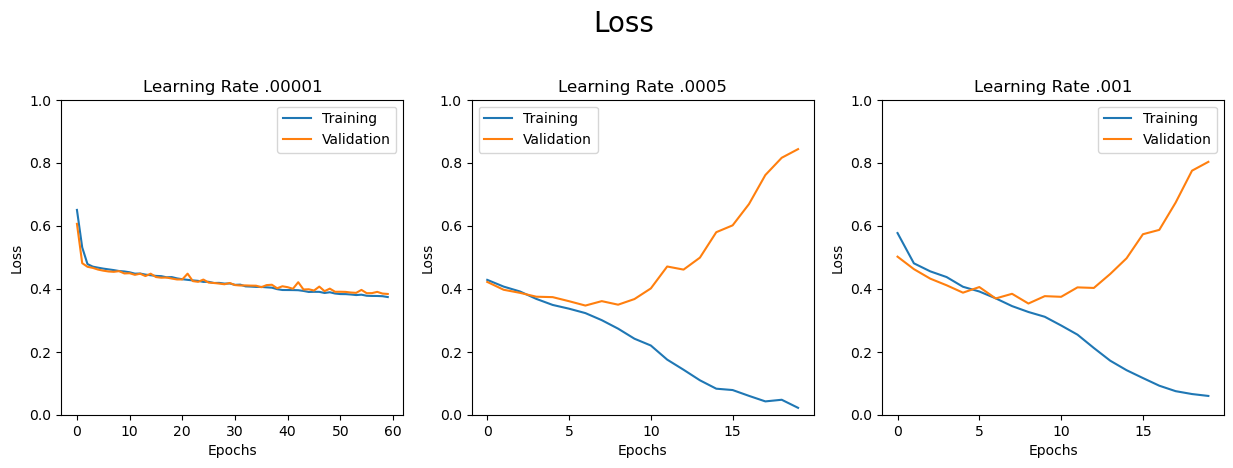

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,Learning Rate .00001,0.836,0.374,0.829,0.383,59
1,Learning Rate .0005,0.994,0.022,0.855,0.347,6
2,Learning Rate .001,0.980,0.060,0.845,0.353,8


In [28]:
#Combine all three runs into one dictionary
c_d = [run_lr2,run_lr2a,run_lr2b]
run_lr2_all = combine_dictionarys (c_d, 'Learning Rate .00001')


# Reaname first run with its learning rate
run_lr3 = {}
run_lr3['Learning Rate .0005'] = run1['5_layer']

#Plot the different rates
plot_all_plots_acc(run_lr2_all|run_lr3|run_lr_1)
plot_all_plots_loss(run_lr2_all|run_lr3|run_lr_1)
create_summary_table(run_lr2_all|run_lr3|run_lr_1)

## Padding
The second hyperparameter that I tuned was padding. My supposition was that adjusting the models padding would not have a huge effect on the model, but I did want to check to see of I was correct about this. The reason that I thought it probably would not make much of a difference, is because according to the dataset information, the tumors are only found in the middle 32x32 pixel portion of the images, so the choices for padding should not make a huge differnce in the model. However, I didn't want to assume that this would be the case, so I ran two scenarios with different choices for padding to see what the results would be.

In [29]:
# Padding Model
# Copy of model 5
pad_2_model_valid = ['Padding = "valid"',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(256, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]
    
# Padding Model
# Copy of model 5
pad_2_model_same = ['Padding = "same"',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(256, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]

In [30]:
# For the first padding comparision, just use the data from the learning rate of .0005
run_pad1 = {}
run_pad1['Padding = "valid"'] = run1['5_layer']

In [31]:
# Run with padding equal to same
tf.random.set_seed(846)
run_pad_2_model = Model(train_data, val_data, Sequential(pad_2_model_same[1]), name = pad_2_model_same[0])
run_pad_2_model.lr = .0005
lr = run_pad_2_model.lr

run_pad_2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=['accuracy'])
run_pad_2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 conv2d_46 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 20, 20, 64)       

In [32]:
#Uncomment out lines again to rerun data.
#run_pad_2_model.fit(20)
#pickle_out('run_pad2.pickle',save_model_info(run_pad_2_model))



In [33]:
# Read in the previously generated data
run_pad2 = pd.read_pickle('run_pad_2.pickle')

### Padding Conclusions
There was a slight difference between the too padding options. However, as suspected, it did not make a significant difference in the output of the model. That being said, 'valid' appeared to do slightly better and also seemed to be more stable in loss reduction. Therefore, for the final model, I will use 'valid' as the padding option I will chose. 

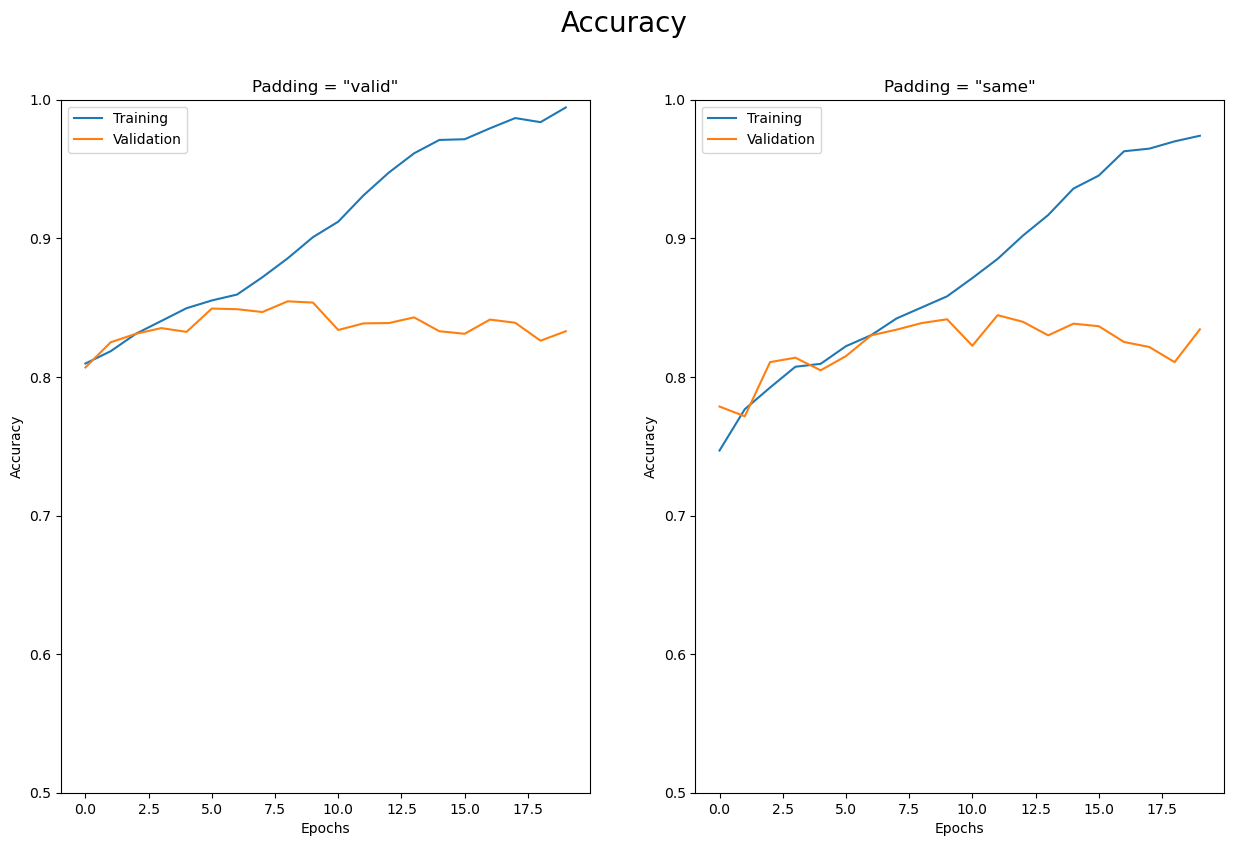

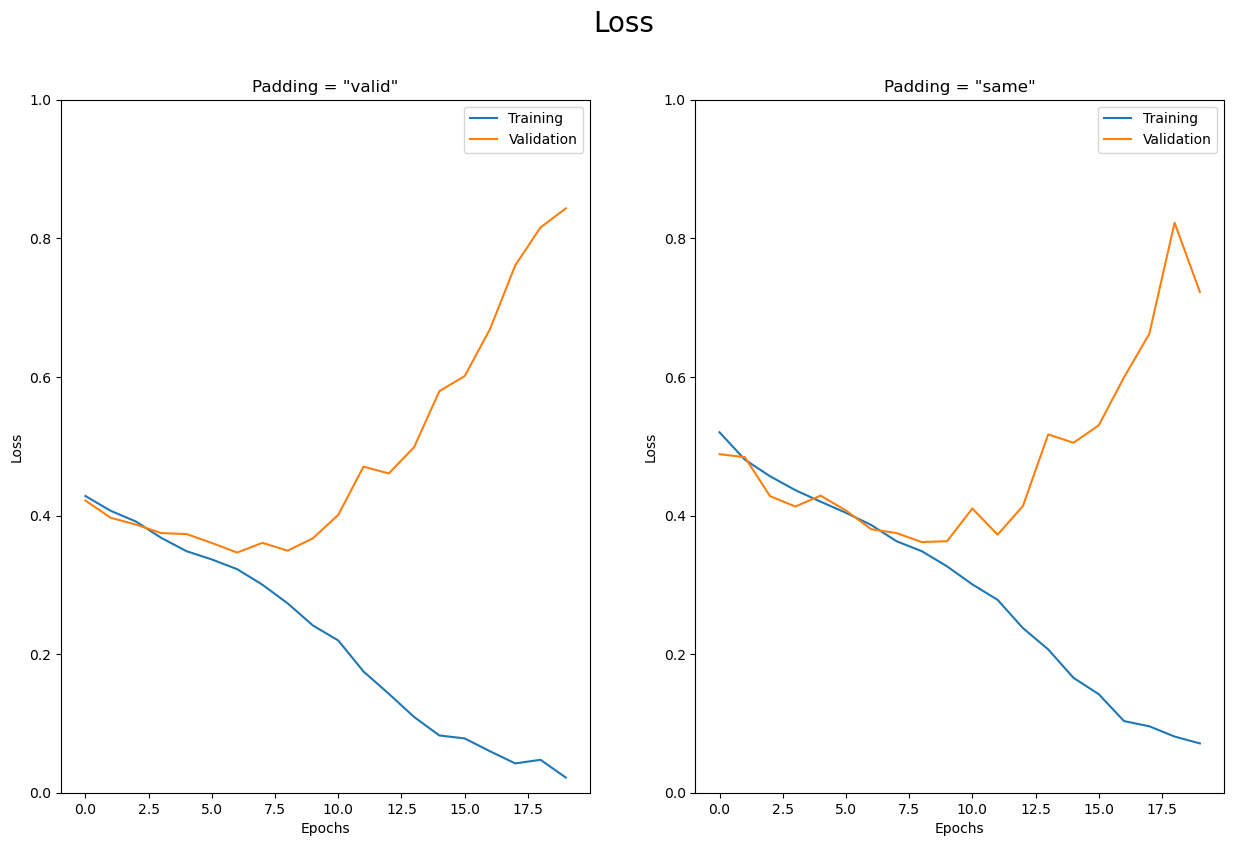

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,"Padding = ""valid""",0.994,0.022,0.855,0.347,6
1,"Padding = ""same""",0.974,0.071,0.845,0.362,8


In [34]:
plot_all_plots_acc(run_pad1|run_pad2)
plot_all_plots_loss(run_pad1|run_pad2)
create_summary_table(run_pad1|run_pad2)


## Optimization Algorithm
Another parameter that I wanted to check was the optimization algorithm. I decided to run my model with RMSProp as well, since it is a common optimization algorithm, to see if there was any improvement over Adam. 

In [35]:
opt_model = ['Model5 with valid',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(256, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]
    

In [36]:
# We have arelady run this model with ADAM. Save it in the history
run_opt1 = {}
run_opt1['ADAM'] = run_pad1['Padding = "valid"']


In [37]:
# Run with padding equal to same
tf.random.set_seed(846)
run_opt2_model = Model(train_data, val_data, Sequential(opt_model[1]), name = 'RMSProp')
run_opt2_model.lr = .0005
lr = run_opt2_model.lr

run_opt2_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=['accuracy'])
run_opt2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 conv2d_51 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 20, 20, 64)       

In [38]:
#Uncomment out lines again to rerun data.
#run_opt2_model.fit(20)
#pickle_out('run_opt2.pickle',save_model_info(run_opt2_model))


### Optimization Conclusions
While there was not a huge difference between the two algorithms, Adam did indeed end up being the better choice, over RMSProp. It has better validation accuracy and loss, and was much more stable in its output. Therefore, in my final model, I continued to use Adam. 

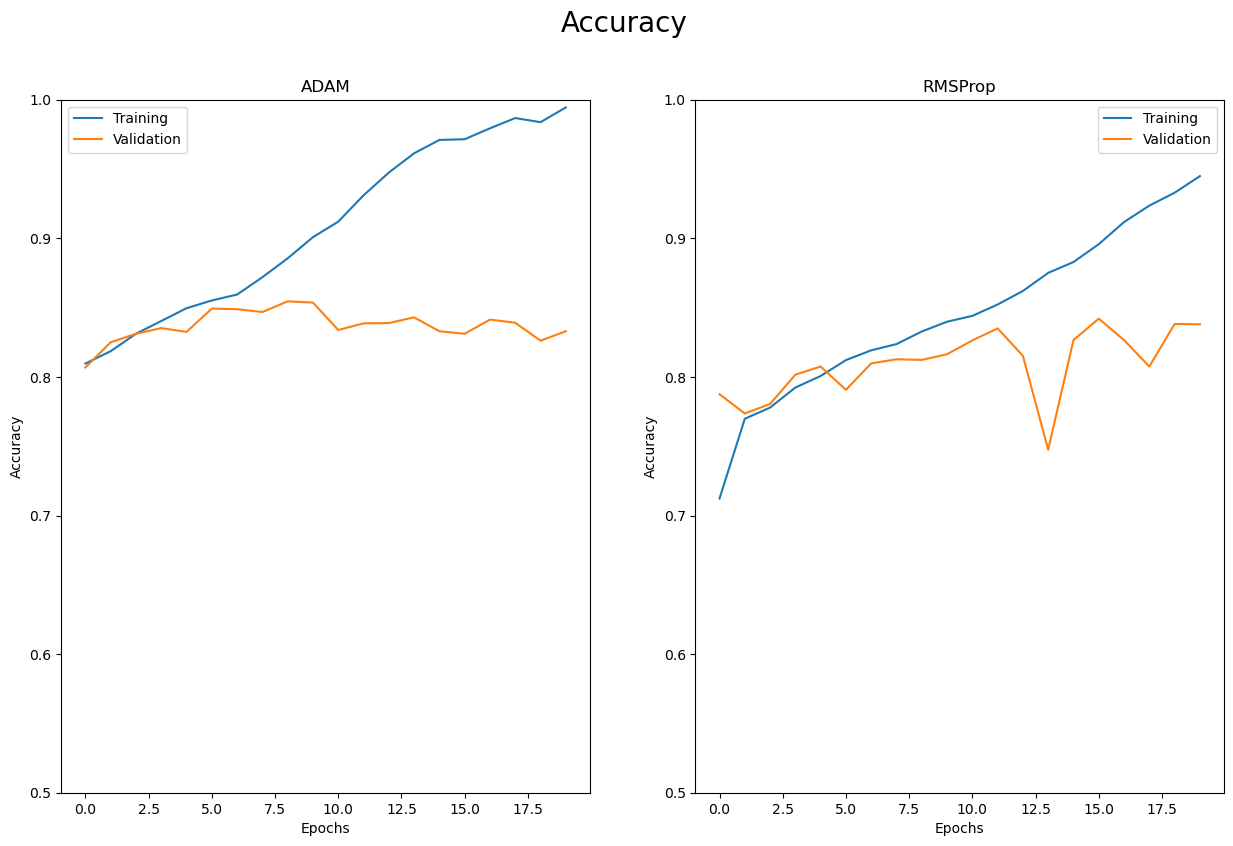

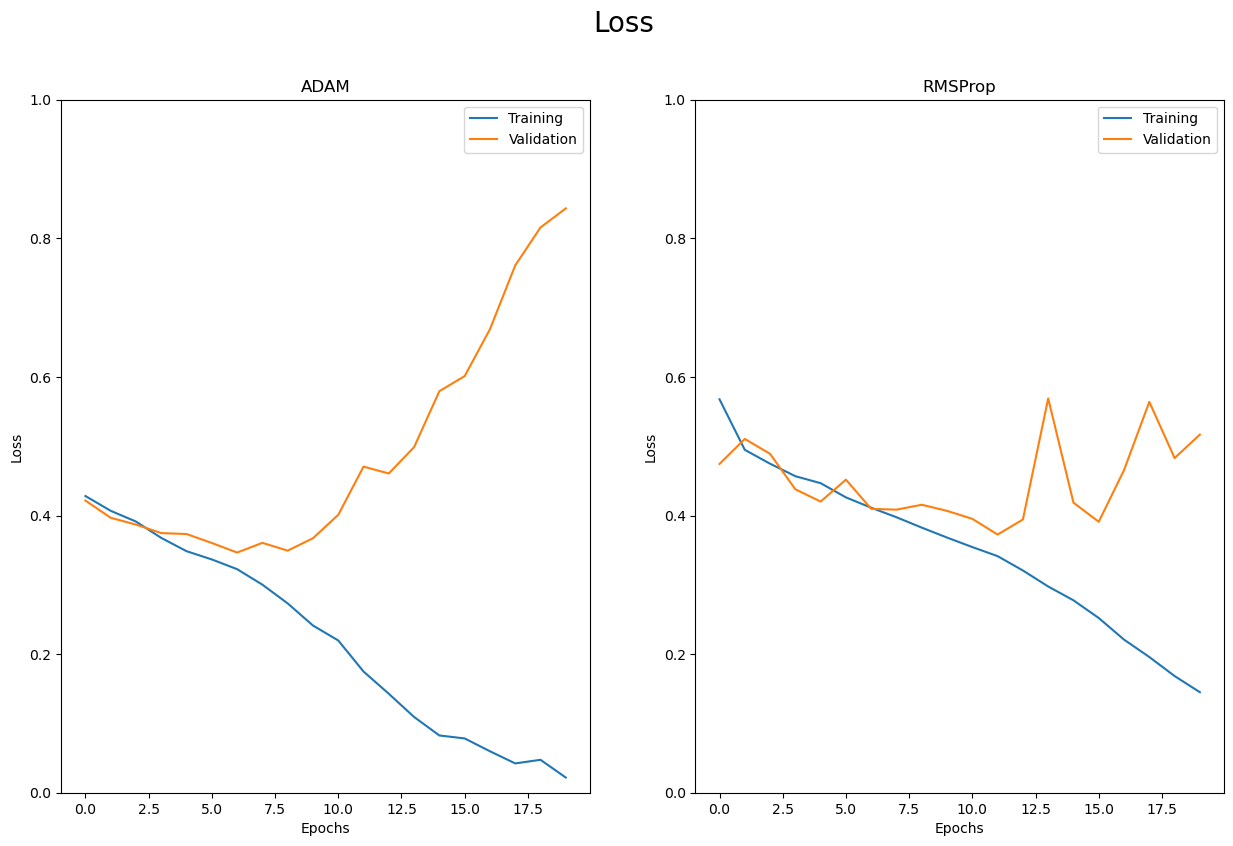

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,ADAM,0.994,0.022,0.855,0.347,6
1,RMSProp,0.945,0.145,0.842,0.373,11


In [39]:
run_opt2 = pd.read_pickle('run_opt2.pickle')
plot_all_plots_acc(run_opt1|run_opt2)
plot_all_plots_loss(run_opt1|run_opt2)
create_summary_table(run_opt1|run_opt2)


### Final Model
For my final model, I decided to use five convolution layers, with a max pool layer after each layer, followed by flattening the image, one more dense layer. and a sigmoid output function. I would initially use a learning rate of .0005 and then reduce that to .00001 at the end to see if I could get any more reduction in validation loss.

Since the goal of this model is to make actual predictions, I wanted to make sure that I did not overfit the data to the training data. For this model, I ran it for 8 epochs at a learning rate of .0005, and then ran it one more time at a learning rate of .00001.

In [40]:
final_model = ['Final Model',[
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(256, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
]]

# Run with padding equal to same
tf.random.set_seed(846)
final_model_1 = Model(train_data, val_data, Sequential(final_model[1]), name = final_model[0])
final_model_1.lr = .0005
lr = final_model_1.lr

final_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=['accuracy'])
final_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 conv2d_56 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 20, 20, 64)       

In [41]:
#final_model_1.fit(8)
#pickle_out('final_model_1a.pickle',save_model_info(final_model_1))
#final_model_1.model.save('final_model_1a.h5', save_format='h5')

In [42]:
final_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=['accuracy'])


In [43]:
#Uncomment out to regenerate data

#final_model_1.fit(1)
#pickle_out('final_model_1b.pickle',save_model_info(final_model_1))
#final_model_1.model.save('final_model_1b.h5', save_format='h5')

### Final Model Conclusions
After running the model, I generated the charts that I had generated for all of my other runs. However, this time what I wanted to verify was that I had not overfit the data, and indeed when looking at the charts, it does not show an inflection point where validation and training loss and accuracy split. This leads me to beleive that I had not overfit the data.

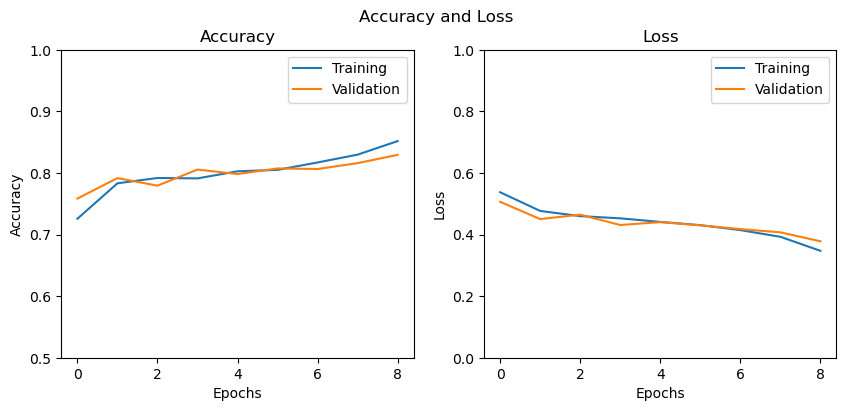

In [44]:
final_model_1a = pd.read_pickle('final_model_1a.pickle')
final_model_1b = pd.read_pickle('final_model_1b.pickle')

final_run_all =  combine_dictionarys ([final_model_1a, final_model_1b], 'Final')
#plot_all_plots_acc(final_run_all)
#plot_all_plots_loss(final_run_all)


plt.figure(figsize = (10,4))

plt.subplot(1, 2, 1)
plt.plot(range(final_run_all['Final']['epochs']), final_run_all['Final']['history']['accuracy'], label = 'Training')
plt.plot(range(final_run_all['Final']['epochs']), final_run_all['Final']['history']['val_accuracy'],   label = 'Validation')
plt.ylim([.5, 1])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(final_run_all['Final']['epochs']), final_run_all['Final']['history']['loss'], label = 'Training')
plt.plot(range(final_run_all['Final']['epochs']), final_run_all['Final']['history']['val_loss'],   label = 'Validation')
plt.ylim([0, 1])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.suptitle('Accuracy and Loss')

plt.show()

## Final Model with Test Data
The last piece of my testing was to use completely new data. Kaggle has a test set with 57,458 images that I used to make predictions with my model. Predictably, the model did not do as well as the validation data. The final accuracy from Kaggle was .7635.

In [45]:
# Create a dataframe for the dataset to load off of. It needs to see both catagories, even though it doesn't use that for predictions in this instance.
# so I changed the first column to a one.
sample_submission_fn = sample_submission.copy() 
sample_submission_fn['id'] =  sample_submission_fn['id'].astype(str) + '.tif'
sample_submission_fn['label'] = sample_submission_fn['label'].astype(str)
sample_submission_fn['label'][0] = '1'
#sample_submission_fn.drop(['label'],axis = 1, inplace = True)
#sample_submission_fn

In [46]:
    #Get the data for the test database
    
    data = ImageDataGenerator()
    test_data = data.flow_from_dataframe(sample_submission_fn,
                                          directory="/kaggle/input/histopathologic-cancer-detection/test",
                                          target_size=(96, 96), 
                                          x_col='id',
                                          y_col = "label",
                                          class_mode='binary',
                                          batch_size=64,
                                          shuffle=False,
                                          validate_filenames= False)

Found 57458 non-validated image filenames belonging to 2 classes.


In [47]:
final_model_model = load_model('final_model_1b.h5')
y_pred_prob_kaggle = final_model_model.predict(test_data)


898/898 [==============================] - 590s 657ms/step


In [49]:
y_pred_kaggle = np.rint(y_pred_prob_kaggle)
y_pred_kaggle

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [50]:
submission = sample_submission.copy()
submission['label'] = (y_pred_kaggle.astype(int))
submission.to_csv('kaggle_predictions1.csv', index = False)
print('Kaggle Score: .7635')

Kaggle Score: .7635


# Conclusion
## Model Discussion on Improvements
There is a lot that I can learn from my model. It is a good start to a model, and while I tried many different things to make it better, it can still be significantly improved. While it does do significantly better than guessing, it is a long way from being very accurate.   There are lots of potential contributing factors to this, and lots of different changes we could make to try and improve the model. 

For one thing, as I discussed earlier, I only trained on ten percent of the dataset. Adding in more data would certainly have a positive effect on the overall accuracy of the dataset. Adding more training data would not be the only way to add data to make it more accurate.  I could add some data that has been generated from the existing data. This can be done by rotating the pictures, or sliding them a few pixels. This generates very similar data to the data that is already there and could possibly enhance the training. 
 
There are other things that could be done to improve accuracy would be to adjust the regularization parameters. This might have an effect on the accuracy of the model.  Batch size is another thing that could effect the model. I had it set to 64, but that was a guess as to what would work well. Perhaps a larger or a smaller batch size could have an effect on the accuracy or speed of the model. 

Changing more aspects of the architecture would be another way in which to improve the model. I certainly made attempts to change the architecture, and saw incremental imprisonments, but nothing that had a drastic effect on accuracy.  However, that does not mean there are not significant changes that could be made in order to drastically improve the image recognition of this model. One thing one could try to improve the model more would be to add one or more dropping layers to see if that would help the model be more accurate. There are lots of other parameters to change, including changing the amount of filters per layer, but unfortunately, testing all of them was not within the scope of this project. 

## Final Conclusion
As we have mentioned, the accuracy of the model is not the best. I was curious though as to were the model was failing, so I generated a confusion matrix of the validation data. If you look at the confusion matrix, the model appear to have more false negatives than it does false positives. I am no medical professional, but I would think you would want a model skew the other direction. To me if would seem that you would want more false positives, and then have a human investigate further, than have a test that says there is no problem, when there is a problem. 

Ultimately, I would not want to try and use this current model for any sort of real life prediction. The accuracy is just not there to make it an effective tool. However, with some changes to the model, this could possibly change.

69/69 [==============================] - 50s 727ms/step


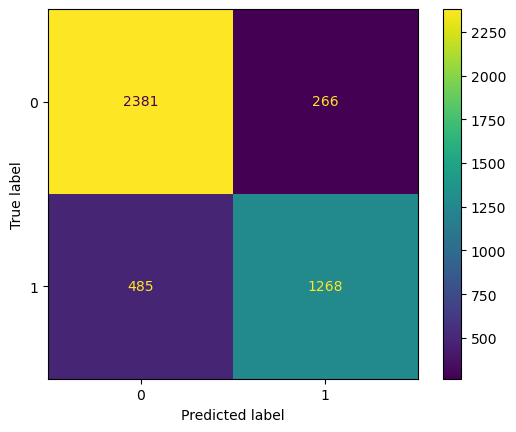

In [51]:
## Geneate a confusion matrix to see if we are mostly getting false postiives or false negatives 

train_labels_small = train_labels.sample(frac = .1, random_state = 648).reset_index()
train_labels_small['label'] = train_labels_small['label'].astype(str)

# calculate train validation split
X_train = train_labels_small.sample(frac = .8, random_state = 59)
val_train = train_labels_small.drop(X_train.index)
y_val = val_train['label']
val_pred = np.rint(final_model_model.predict(val_data)).astype(int).astype(str)
cm = confusion_matrix(y_val, val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()


# References

Alake, Richmond. "Understanding and Implementing LeNet-5 CNN Architecture (Deep Learning)."  Towrds Data Science. June 25th, 2020. https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342

Brownlee,Jason. "Gentle Introduction to the Adam Optimization Algorithm for Deep Learning."  Machine Learning Mastery. July 3rd, 2017.  https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

Caulfield, Jack. “A Step-by-Step Guide to the Writing Process.” Scribbr. April 24, 2020. https://www.scribbr.com/­academic-writing/­writing-process/.

Chng, Zhe Ming. "Three Ways to Build Machine Learning Models in Keras." Machine Learning Mastery. August 4th, 2022 https://machinelearningmastery.com/three-ways-to-build-machine-learning-models-in-keras/

"Image Classification." TensorFlow.org. July 7th, 2023. https://www.tensorflow.org/tutorials/images/classification

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection
            




